# Compare VLMs

The [VLM dashboard](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard) has a list of VLMs and their performance scores.

We want to pick a small-ish (under 8B) model that is sufficient to generate captions for animal face images in the AFHQ dataset.

## Install Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install peft==0.13.2 flash_attn==2.7.* qwen_vl_utils==0.0.8 transformers==4.47.* autoawq==0.2.* jinja2==3.1.4 xformers==0.0.28 bitsandbytes==0.45.0



Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.4.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1

In [3]:
import transformers
import jinja2
import bitsandbytes

print(transformers.__version__)
print(jinja2.__version__)
print(bitsandbytes.__version__)
jinja2.parser

4.47.0
3.1.4
0.45.0


<module 'jinja2.parser' from '/home/ubuntu/.local/lib/python3.11/site-packages/jinja2/parser.py'>

## Load Images

In [4]:
from torch.utils.data import Dataset
from datasets import load_dataset
from torchvision import transforms
import torch
from transformers import AutoModel, AutoTokenizer


dataset_name = "zzsi/afhq64_16k"


class HuggingFaceDataset(Dataset):
    def __init__(self, dataset_path: str, transform=None):
        self.dataset = load_dataset(dataset_path, split="train")
        self.transform = transform
        self.image_key = self.find_image_key()

    def find_image_key(self) -> str:
        # Check if the dataset has the "image" key
        # NOTE: Can exapnd this to other common keys if needed
        if "image" in self.dataset[0].keys():
            return "image"
        raise KeyError("Dataset does not have an 'image' key")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx][self.image_key]
        image = image.convert("RGB")  # Convert to RGB to ensure 3 channels
        # By default, set label to 0 to conform to current expected batch format
        label = 0
        if self.transform:
            image = self.transform(image)
        return image, label



transforms_list = [
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
    
transform = transforms.Compose(transforms_list)
full_dataset = HuggingFaceDataset(dataset_name, transform=transform)


print(f"dataset has {len(full_dataset)} images")
print(f"first image shape: {full_dataset[0][0].shape}")

dataset has 14630 images
first image shape: torch.Size([3, 64, 64])


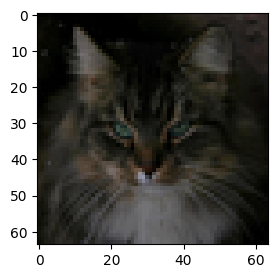

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(3, 3))
first_image = full_dataset[0][0].permute(1, 2, 0).numpy()
plt.imshow(first_image)
plt.show()


In [11]:
# normalize the image to [0, 1]
import numpy as np
from PIL import Image

first_image = (first_image - first_image.min()) / max(first_image.max() - first_image.min(), 1e-6)
pil_image = Image.fromarray((first_image * 255).astype(np.uint8))
pil_image.save("first_image.jpg")

## QWEN-VL

In [8]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct-AWQ", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-2B-Instruct-AWQ",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct-AWQ")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct-AWQ", min_pixels=min_pixels, max_pixels=max_pixels)



2024-12-06 14:56:55.329856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 14:56:55.342432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 14:56:55.357560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 14:56:55.362094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 14:56:55.373408: I tensorflow/core/platform/cpu_feature_guar

In [21]:
# base64 encoded image using jpeg
import base64
import io
from PIL import Image
import numpy as np

# first write the image to a bytes object
image_bytes = io.BytesIO()

pil_image.save(image_bytes, format="JPEG")
image_bytes = image_bytes.getvalue()
prefix = "data:image/jpeg;base64,"
image_base64 = prefix + base64.b64encode(image_bytes).decode('utf-8')


messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_base64,
                # "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preprocess the inputs


# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

["The image depicts a cat with a long, flowing coat that appears to be a Maine Coon breed. The cat has a fluffy, dense fur that is predominantly white with some darker markings, particularly around the eyes and around the neck. The cat's eyes are large and expressive, and it has a long, curved tail that is slightly curled. The cat's ears are pointed and have a distinct, fluffy texture. The overall appearance of the cat suggests it is well-groomed and healthy."]


## CogVLM

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_PATH = "THUDM/cogvlm2-llama3-chat-19B-int4"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TORCH_TYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[
    0] >= 8 else torch.float16

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True
)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=TORCH_TYPE,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
).eval()

text_only_template = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. USER: {} ASSISTANT:"

query = "Describe this image."
history = []

input_by_model = model.build_conversation_input_ids(
                tokenizer,
                query=query,
                history=history,
                images=[pil_image],
                template_version='chat'
            )

inputs = {
    'input_ids': input_by_model['input_ids'].unsqueeze(0).to(DEVICE),
    'token_type_ids': input_by_model['token_type_ids'].unsqueeze(0).to(DEVICE),
    'attention_mask': input_by_model['attention_mask'].unsqueeze(0).to(DEVICE),
    'images': [[input_by_model['images'][0].to(DEVICE).to(TORCH_TYPE)]] if pil_image is not None else None,
}
gen_kwargs = {
    "max_new_tokens": 128,
    "pad_token_id": 128002,
}

with torch.no_grad():
    outputs = model.generate(**inputs, **gen_kwargs)
    outputs = outputs[:, inputs['input_ids'].shape[1]:]
    response = tokenizer.decode(outputs[0])
    response = response.split("<|end_of_text|>")[0]
    print("\nCogVLM2:", response)


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


TypeError: GenerationMixin._extract_past_from_model_output() got an unexpected keyword argument 'standardize_cache_format'

## Try Blip-2

## Try MiniCPM-V-2

In [7]:
model_name = 'openbmb/MiniCPM-V-2'
model = AutoModel.from_pretrained(model_name, trust_remote_code=True,
    attn_implementation='sdpa', torch_dtype=torch.bfloat16) # sdpa or flash_attention_2, no eager
# For Nvidia GPUs support BF16 (like A100, H100, RTX3090)
model = model.to(device='cuda', dtype=torch.bfloat16)
# For Nvidia GPUs do NOT support BF16 (like V100, T4, RTX2080)
#model = model.to(device='cuda', dtype=torch.float16)
# For Mac with MPS (Apple silicon or AMD GPUs).
# Run with `PYTORCH_ENABLE_MPS_FALLBACK=1 python test.py`
#model = model.to(device='mps', dtype=torch.float16)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
_ = model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
import numpy as np
from PIL import Image

print(first_image.shape, first_image.max() * 255)

pil_image = Image.fromarray((first_image * 255).astype(np.uint8))

question = 'What is in the image?'
msgs = [{'role': 'user', 'content': question}]

res, context, _ = model.chat(
    image=pil_image,
    msgs=msgs,
    tokenizer=tokenizer,
    context=None,
    # sampling=True,
    # temperature=0.7
)
print(res)

(64, 64, 3) 166.00000530481339


AttributeError: 'Qwen2VLForConditionalGeneration' object has no attribute 'chat'